***DSCI 100 Project proposal***

*Predicting news article popularity*

    Group 28: Natsumi Tadakuma, Jackie Huang, Cindy Chen, Nikko Dumrique


**Introduction**

In this proposal, we aim to predict the popularity based on News Popularity Data Set from https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity. The dataset summarizes statistical features about articles published on Mashable in a period of two years. Although the data set’s primary concern is predicting popularity, there is no inherent categorical variable to measure it. Therefore, for our analysis we will define the popularity of a news article based on the number of shares it has. We have created 4 categories of which define a range of shares; Not popular, somewhat popular, popular, and viral. 


| | Not popular | Somewhat popular | popular | viral |
|---| --- | --- | --- | --- |
|Number of Shares | [0,500) | [500,1400) | [1400,3300) | 3300+ |

**Preliminary exploratory data analysis**

The data we are trying to extract is in zip format. To extract the actual csv file from the web, we need to create a temporary file for the zip file, then unzip the file locally to read. On top of this, since the zip file also contains a .names file, we need to specify what we want to read when doing read_csv.


Importing the libraries:

In [30]:
library(tidyverse)
library(tidyr)
library(repr)
library(tidymodels)
library(ggplot2)

In [31]:
options(repr.matrix.max.rows = 5, repr.matrix.max.cols = 64)
options(repr.plot.width = 30, repr.plot.height = 10)

Importing the dataset:

In [32]:
#download the zip file into a temporary file
temp <- tempfile()
temp_dir <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00332/OnlineNewsPopularity.zip", temp, mode="wb")
OnlineNewsPopularity_unzipped <- unzip(temp, exdir = temp_dir)

#read the csv within the unzipped_contents
online_news_pop_csv <- OnlineNewsPopularity_unzipped[2] #may be unzipped_contents[1] if you get an error
online_news_pop_data <- read_csv(online_news_pop_csv)
online_news_pop_data
unlink(c(temp, temp_dir))

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,496,496,496,1,0,0,0,0,0,0,0,0.5003312,0.37827893,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.04566210,0.013698630,0.7692308,0.2307692,0.3786364,0.10000000,0.7,-0.3500000,-0.600,-0.2000000,0.5,-0.1875,0.0,0.1875,593
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.7997557,0.05004668,0.05009625,0.05010067,0.05000071,0.3412458,0.14894781,0.04313725,0.015686275,0.7333333,0.2666667,0.2869146,0.03333333,0.7,-0.1187500,-0.125,-0.1000000,0.0,0.0000,0.5,0.0000,711
http://mashable.com/2013/01/07/apple-40-billion-app-downloads/,731,9,211,0.5751295,1,0.6638655,3,1,1,0,4.393365,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,918,918,918,1,0,0,0,0,0,0,0,0.2177923,0.03333446,0.03335142,0.03333354,0.68218829,0.7022222,0.32333333,0.05687204,0.009478673,0.8571429,0.1428571,0.4958333,0.10000000,1.0,-0.4666667,-0.800,-0.1333333,0.0,0.0000,0.5,0.0000,1500
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/ukraine-blasts/,8,6,682,0.5394933,1,0.6926605,10,1,1,0,4.975073,5,0,0,0,0,0,1,-1,0,-1.0,0,843300,254600,0.000,3384.317,1777.896,452,452,452,0,0,1,0,0,0,0,0,0.04000361,0.04000349,0.83998726,0.04000210,0.04000355,0.3585776,-0.008065863,0.02052786,0.02346041,0.4666667,0.5333333,0.2368506,0.0625,0.5,-0.2052455,-0.5,-0.0125,0.0000000,0.00,0.5000000,0.00,1100
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,0,1,0,0,0,0,-1,97,23.5,205600,843300,366200,3035.081,3613.513,3296.909,2100,2100,2100,0,0,1,0,0,0,0,0,0.05000126,0.79933895,0.05000041,0.05065874,0.05000064,0.5178932,0.104891775,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,0.1000,0.5,-0.2000000,-0.2,-0.2000,0.3333333,0.25,0.1666667,0.25,1300


First, we need to clean and wrangle our data before we can perform any data analysis on it. In accordance with our prediction question, we first mutate the shares column based on the criterias we set to obtain a new column named popularity as our target column. Then we use pivot_longer to combine weekday_is_* columns into one; using values_drop_na and names_prefix to tidy up column names and values. Then we repeat these steps on data_channel_is_* to tidy up these columns as well.


summary on the number of shares:

In [33]:
summary(online_news_pop_data$shares)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1     946    1400    3395    2800  843300 

tidying the data:

In [34]:
news = online_news_pop_data %>% 
      mutate(popularity = ifelse(shares < 500, "Not_Popular",
                          ifelse(shares %in% 500:1399, "Somewhat_Popular",
                          ifelse(shares %in% 1400:3299, "Popular", "Viral")))) %>% 
      mutate(popularity = as_factor(popularity))

In [35]:
# combining the weekdays and data channels into one column
# which(colnames(news)=="data_channel_is_lifestyle")

news[,14:19][news[,14:19] == 0] = NA

news = news %>% 
    pivot_longer(data_channel_is_lifestyle:data_channel_is_world,
                 names_to = "Channel",
                 names_prefix = "data_channel_is_",
                 values_to = "Value",
                 values_drop_na = TRUE) %>% 
  select(-Value)

# which(colnames(news)=="weekday_is_monday")
news[,32:38][news[32:38] == 0] = NA
news = news %>% 
    pivot_longer(weekday_is_monday:weekday_is_sunday,
                 names_to = "weekday",
                 names_prefix = "weekday_is_",
                 values_to = "value",
                 values_drop_na = TRUE) %>% 
  select(-value)
news

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity,Channel,weekday
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.3782789,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,monday
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.3782789,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,tuesday
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.3782789,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,wednesday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,-1,97,23.5,205600,843300,366200,3035.081,3613.513,3296.909,2100,2100,2100,NA,0.05000126,0.799339,0.05000041,0.05065874,0.05000064,0.5178932,0.1048918,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,0.1,0.5,-0.2,-0.2,-0.2,0.3333333,0.25,0.1666667,0.25,1300,Somewhat_Popular,entertainment,friday
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,-1,97,23.5,205600,843300,366200,3035.081,3613.513,3296.909,2100,2100,2100,NA,0.05000126,0.799339,0.05000041,0.05065874,0.05000064,0.5178932,0.1048918,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,0.1,0.5,-0.2,-0.2,-0.2,0.3333333,0.25,0.1666667,0.25,1300,Somewhat_Popular,entertainment,saturday


In [47]:
news_dropped_extremas <- news %>% 
    select(-c(kw_min_min, kw_max_min,kw_min_max, kw_max_max, 
              kw_min_avg, kw_max_avg, self_reference_min_shares, self_reference_max_shares,
             min_positive_polarity, max_positive_polarity, min_negative_polarity, max_negative_polarity)) %>% 
    select(-c(LDA_00, LDA_01, LDA_02, LDA_03, LDA_04))
news_dropped_extremas

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_avg_min,kw_avg_max,kw_avg_avg,self_reference_avg_sharess,is_weekend,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity,Channel,weekday
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,496,NA,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,-0.35,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,monday
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,496,NA,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,-0.35,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,tuesday
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,496,NA,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,-0.35,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,wednesday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,23.5,366200,3296.909,2100,NA,0.5178932,0.1048918,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,-0.2,0.3333333,0.25,0.1666667,0.25,1300,Somewhat_Popular,entertainment,friday
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,23.5,366200,3296.909,2100,NA,0.5178932,0.1048918,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,-0.2,0.3333333,0.25,0.1666667,0.25,1300,Somewhat_Popular,entertainment,saturday


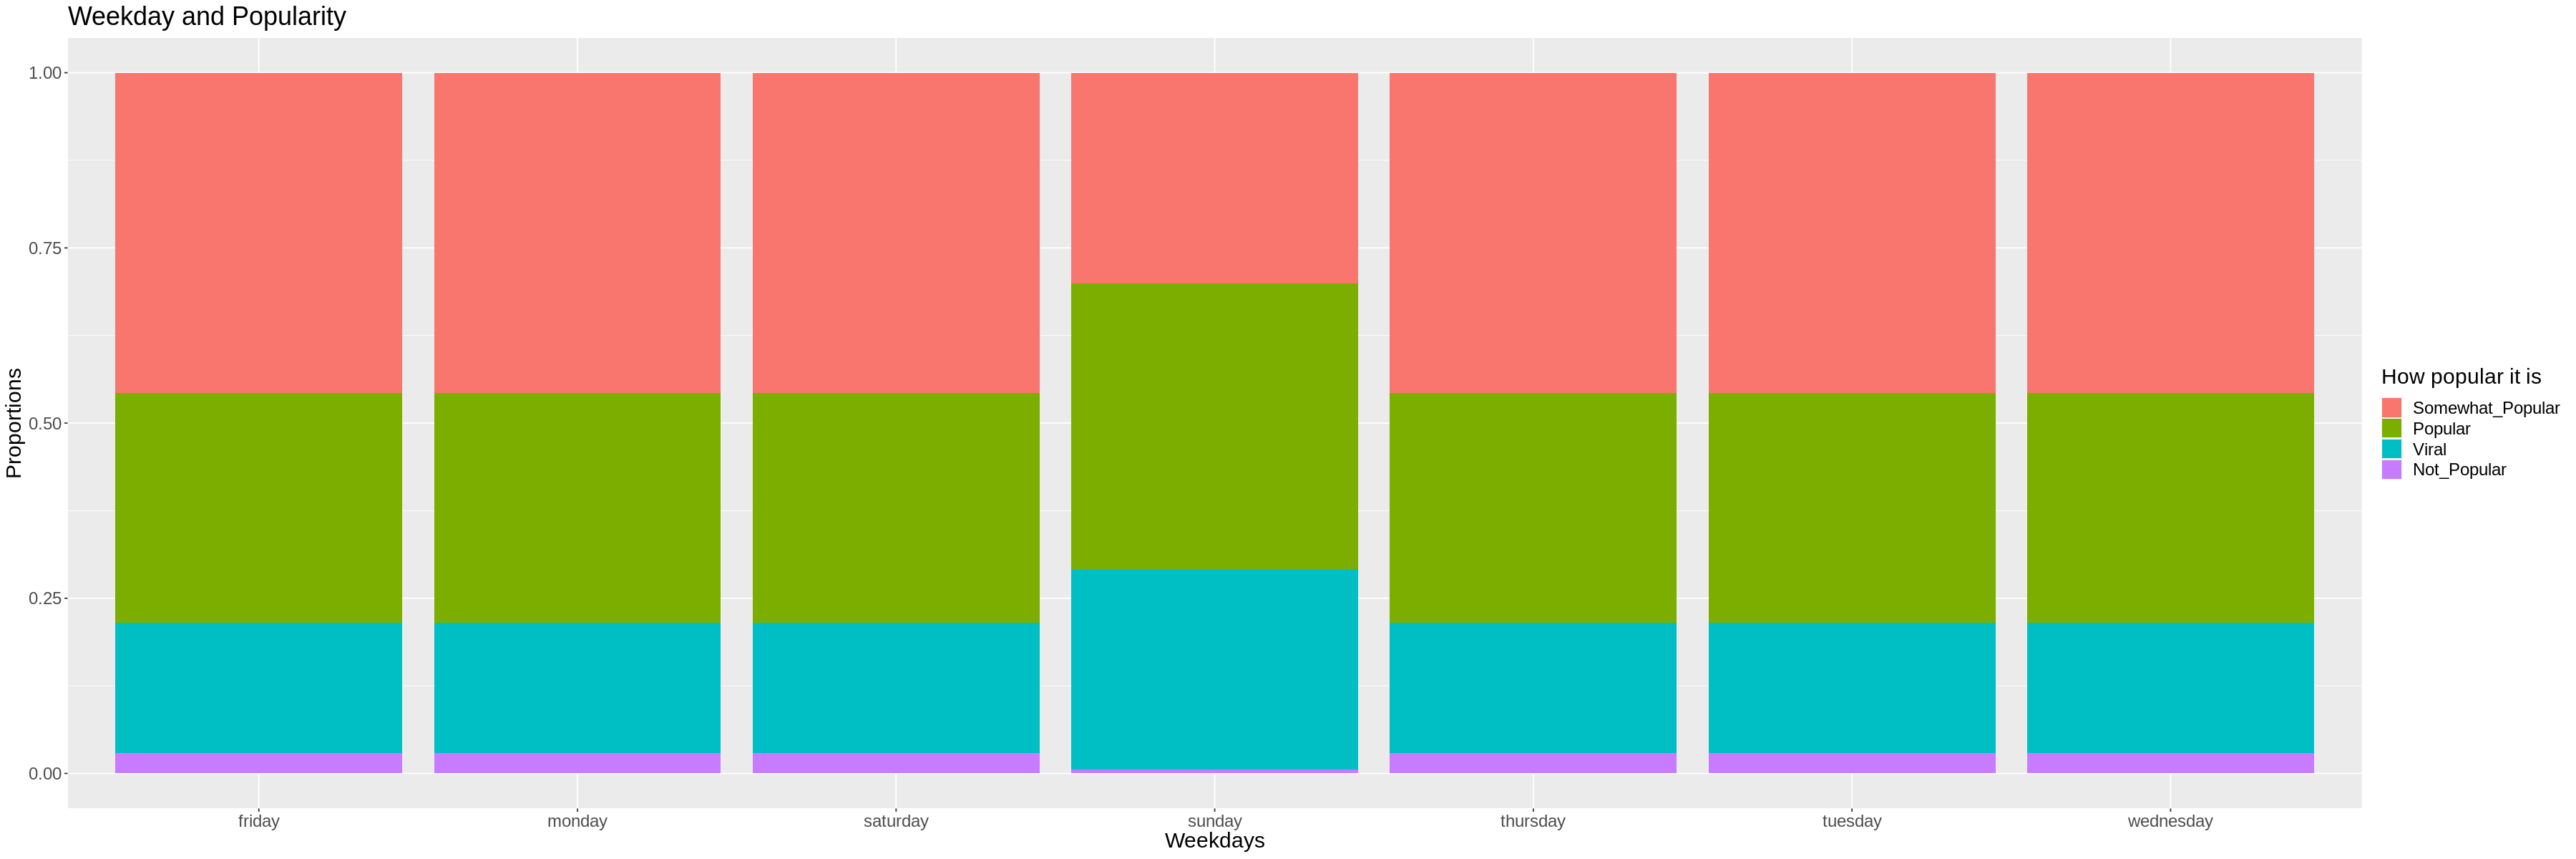

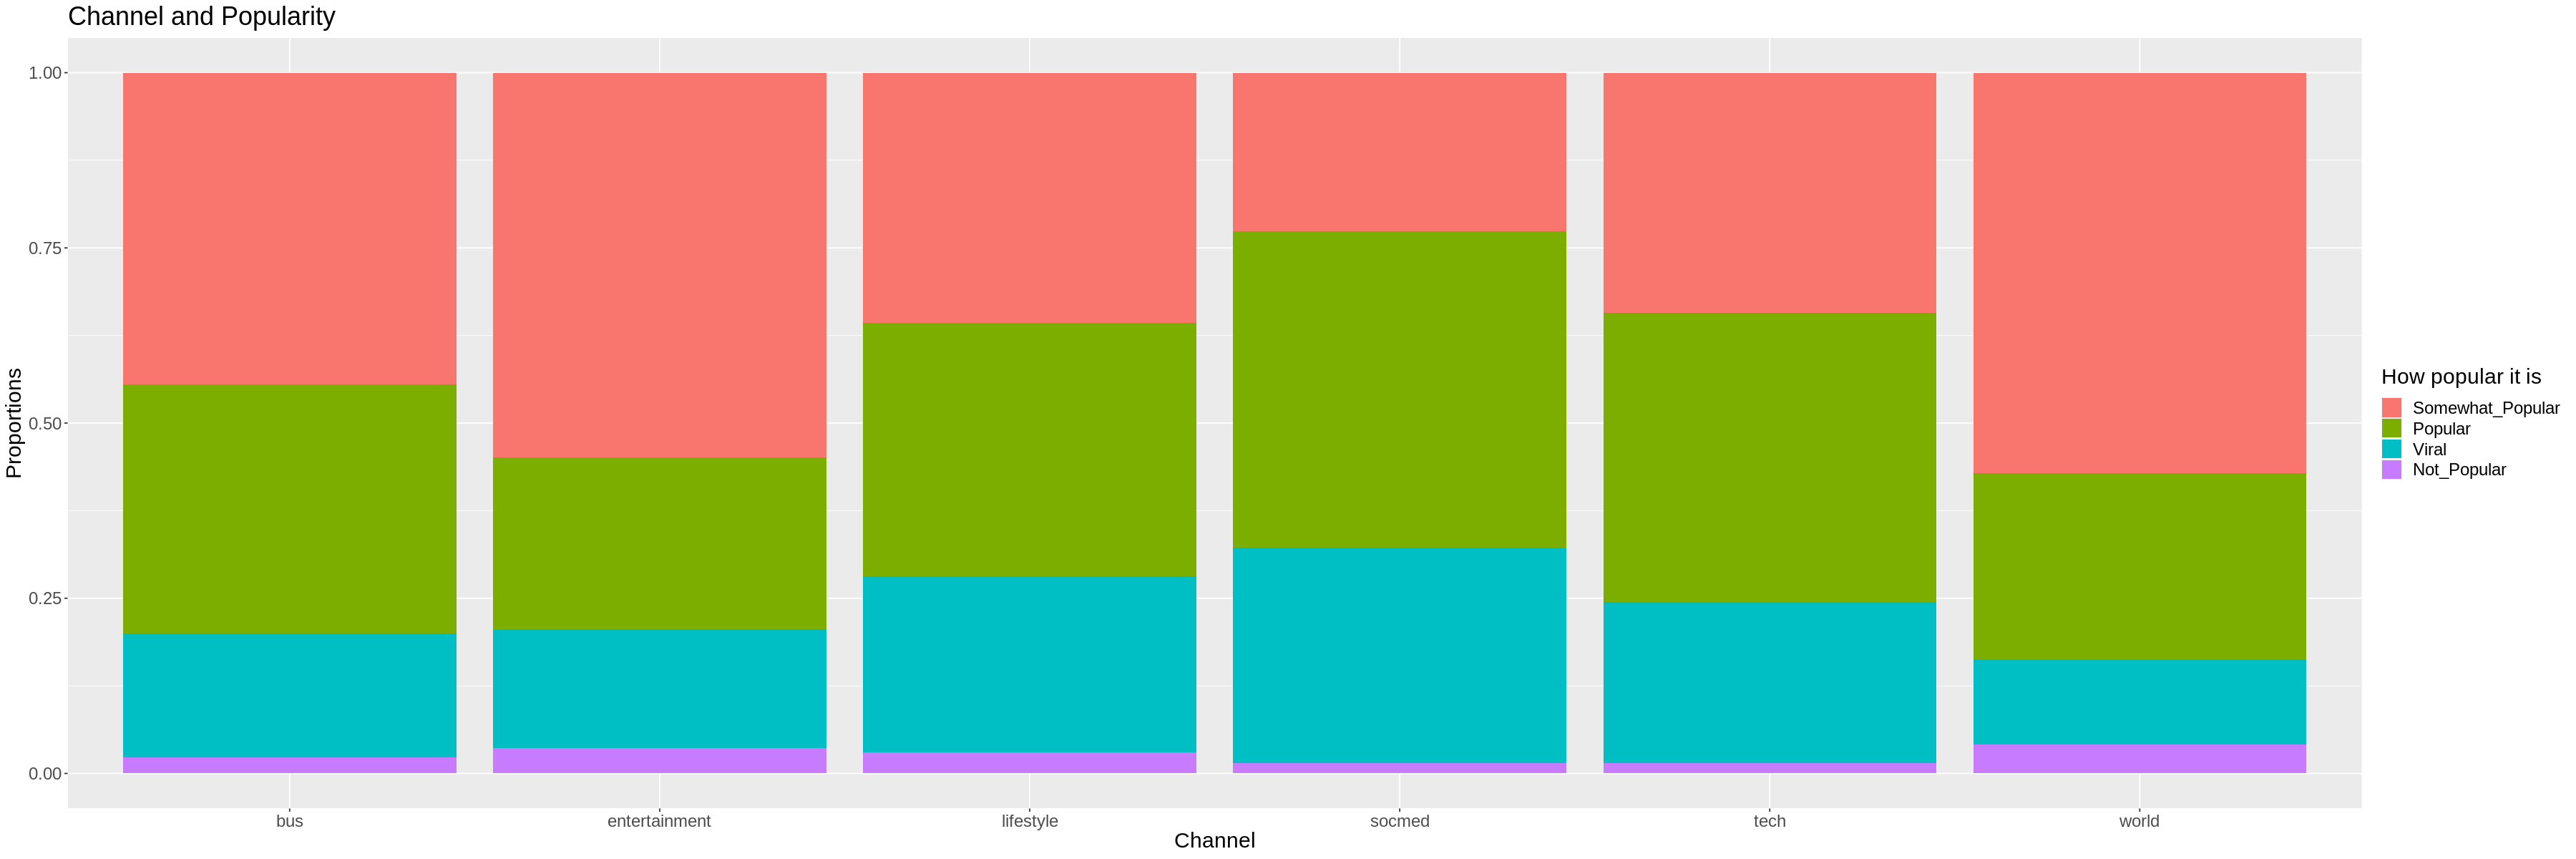

In [36]:
#plots
pltWeekdays = news %>% 
            ggplot(aes(x = weekday, fill = popularity)) +
            geom_bar(position = "fill") + 
            labs( x = "Weekdays", y = "Proportions", fill = "How popular it is", 
                  title = "Weekday and Popularity") + 
            theme(text = element_text(size = 18))
pltWeekdays

pltChannels = news %>% 
            ggplot(aes(x = Channel, fill = popularity)) +
            geom_bar(position = "fill") + 
            labs( x = "Channel", y = "Proportions", fill = "How popular it is", 
                  title = "Channel and Popularity") +
            theme(text = element_text(size = 18))
pltChannels





Once we have prepared the data, we split our dataset by 75% to create train and test sets. Using the training set, we were able to create a reporting table containing the number of missing values, number of observations and the mean value for each of the predictors. Furthermore, we also used the training set to explore the relationships between each predictor and the popularity of an article. Note that we only use Channel in the plot as from the bar plot prior, we already established that an article is most likely to be popular if it is published in Sunday.





seperating our training set:

In [37]:
splitted_data <- initial_split(news, prop = 0.75, strata = popularity)  
training_set <- training(splitted_data)   
testing_set <- testing(splitted_data)
training_set
testing_set

url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity,Channel,weekday
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.3782789,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,monday
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.3782789,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,tuesday
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.3782789,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.0456621,0.01369863,0.7692308,0.2307692,0.3786364,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0,0.1875,593,Somewhat_Popular,entertainment,thursday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,-1,97,23.5,205600,843300,366200,3035.081,3613.513,3296.909,2100,2100,2100,NA,0.05000126,0.799339,0.05000041,0.05065874,0.05000064,0.5178932,0.1048918,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,0.1,0.5,-0.2,-0.2,-0.2,0.3333333,0.25,0.1666667,0.25,1300,Somewhat_Popular,entertainment,friday
http://mashable.com/2014/12/27/youtube-channels-2015/,8,10,157,0.7019868,1,0.8461538,1,1,0,2,4.471338,4,-1,97,23.5,205600,843300,366200,3035.081,3613.513,3296.909,2100,2100,2100,NA,0.05000126,0.799339,0.05000041,0.05065874,0.05000064,0.5178932,0.1048918,0.06369427,0.01273885,0.8333333,0.1666667,0.2473377,0.1,0.5,-0.2,-0.2,-0.2,0.3333333,0.25,0.1666667,0.25,1300,Somewhat_Popular,entertainment,saturday


url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity,Channel,weekday
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
http://mashable.com/2013/01/07/amazon-instant-video-browser/,731,12,219,0.6635945,1,0.8153846,4,2,1,0,4.680365,5,0,0,0,0,0,0,0,0,0,496,496,496,NA,0.5003312,0.37827893,0.04000468,0.04126265,0.04012254,0.5216171,0.09256198,0.04566210,0.01369863,0.7692308,0.2307692,0.3786364,0.10000000,0.7,-0.35000,-0.600,-0.2,0.5,-0.1875,0.0,0.1875,593,Somewhat_Popular,entertainment,wednesday
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,4,0,0,0,0,0,0,0,0,0,0,0,0,NA,0.7997557,0.05004668,0.05009625,0.05010067,0.05000071,0.3412458,0.14894781,0.04313725,0.01568627,0.7333333,0.2666667,0.2869146,0.03333333,0.7,-0.11875,-0.125,-0.1,0.0,0.0000,0.5,0.0000,711,Somewhat_Popular,bus,monday
http://mashable.com/2013/01/07/ap-samsung-sponsored-tweets/,731,9,255,0.6047431,1,0.7919463,3,1,1,0,4.913725,4,0,0,0,0,0,0,0,0,0,0,0,0,NA,0.7997557,0.05004668,0.05009625,0.05010067,0.05000071,0.3412458,0.14894781,0.04313725,0.01568627,0.7333333,0.2666667,0.2869146,0.03333333,0.7,-0.11875,-0.125,-0.1,0.0,0.0000,0.5,0.0000,711,Somewhat_Popular,bus,friday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
http://mashable.com/2014/12/27/samsung-app-autism/,8,11,346,0.5290520,1,0.6847826,9,7,1,1,4.523121,8,-1,671,173.125,26900,843300,374962.5,2514.743,4004.343,3031.116,11400,48000,37033.33,NA,0.02503777,0.02500062,0.1517012,0.02500011,0.77326035,0.4826786,0.1419643,0.03757225,0.014450867,0.7222222,0.2777778,0.3337912,0.1000000,0.75,-0.2600000,-0.5,-0.125,0.1,0,0.4,0,1800,Popular,tech,tuesday
http://mashable.com/2014/12/27/seth-rogen-james-franco-will-live-tweet-the-interview/,8,12,328,0.6962963,1,0.8850575,9,7,3,48,4.405488,7,-1,616,184.000,6500,843300,192985.7,1664.268,5470.169,3411.661,2100,2100,2100.00,NA,0.02934870,0.02857493,0.2318661,0.68163487,0.02857542,0.5643743,0.1942493,0.03963415,0.009146341,0.8125000,0.1875000,0.3748252,0.1363636,0.70,-0.2111111,-0.4,-0.100,0.3,1,0.2,1,1900,Popular,socmed,friday


In [38]:
training_report <- news %>% 
    select(n_unique_tokens, average_token_length, kw_avg_min, kw_avg_max,)
training_report

n_unique_tokens,average_token_length,kw_avg_min,kw_avg_max
<dbl>,<dbl>,<dbl>,<dbl>
0.6635945,4.680365,0,0
0.6635945,4.680365,0,0
0.6635945,4.680365,0,0
⋮,⋮,⋮,⋮
0.7019868,4.471338,23.5,366200
0.7019868,4.471338,23.5,366200


In [39]:
report <- tibble(n_unique_tokens = length(training_report$n_unique_tokens[training_report$n_unique_tokens == 0]),
            average_token_length = length(training_report$average_token_length[training_report$n_unique_tokens == 0]),
            kw_avg_min = length(training_report$kw_avg_min[training_report$kw_avg_min == 0]),
            kw_avg_max = length(training_report$kw_avg_max[training_report$kw_avg_max ==0])) 
report <- report %>% 
        add_row(n_unique_tokens = 203249 - max(report[1,]),
            average_token_length = 203249 - max(report[1,]),
            kw_avg_min = 203249 - max(report[1,]),
            kw_avg_max = 203249 - max(report[1,])) 
#setting all the zeros to NA
training_report[,1:4][training_report[,1:4] == 0] = NA

report <- report %>% 
    add_row(n_unique_tokens = mean(training_report$n_unique_tokens, na.rm = TRUE),
            average_token_length = mean(training_report$average_token_length, na.rm = TRUE),
           kw_avg_min = mean(training_report$kw_avg_min, na.rm = TRUE),
           kw_avg_max = mean(training_report$kw_avg_max, na.rm = TRUE))

row.names(report) = c("missing_value", "number_of_observations", "the_means_of_each_predictors")
report

Warning message:
“Setting row names on a tibble is deprecated.”


,n_unique_tokens,average_token_length,kw_avg_min,kw_avg_max
,<dbl>,<dbl>,<dbl>,<dbl>
missing_value,3.280000e+03,3.280000e+03,451.0000,438
number_of_observations,1.999690e+05,1.999690e+05,199969.0000,199969
the_means_of_each_predictors,5.582743e-01,4.683252e+00,309.7929,242209


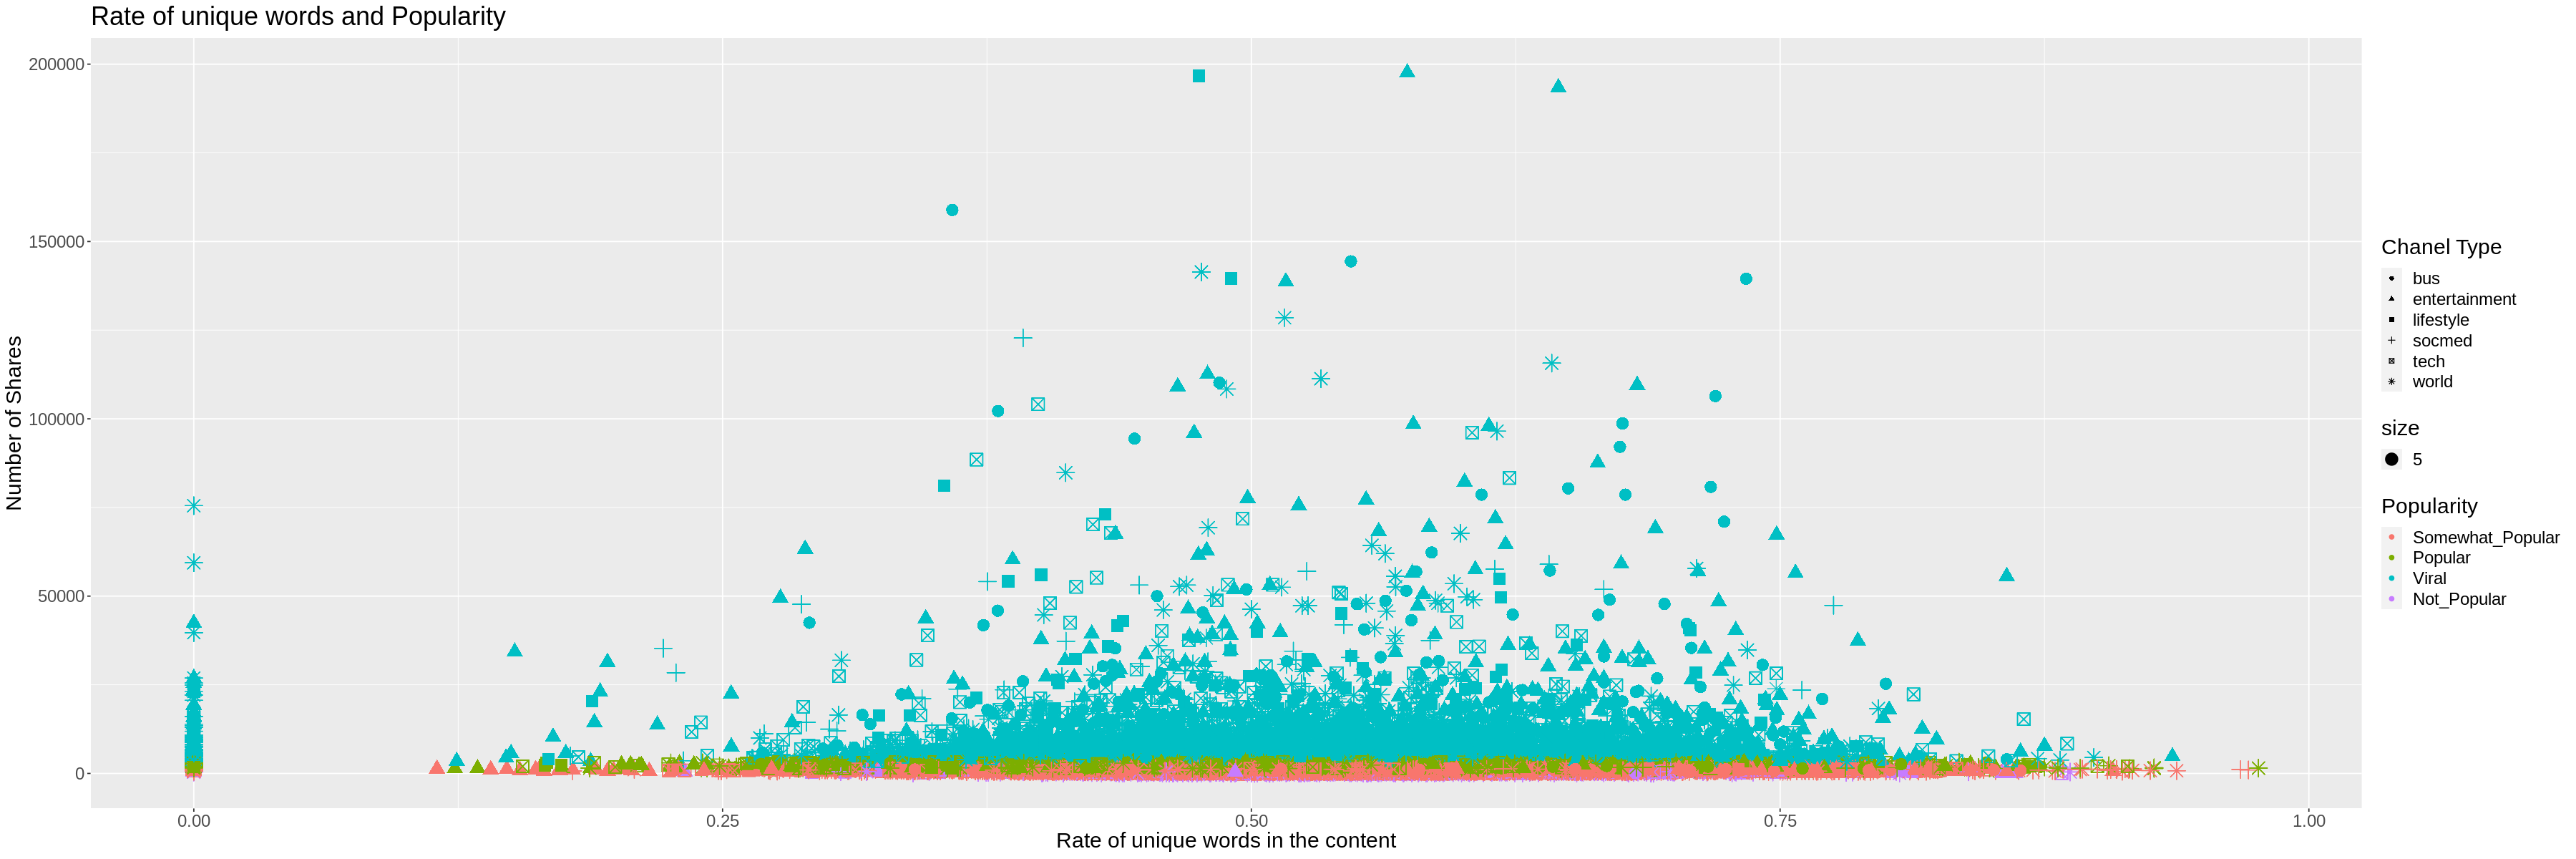

In [40]:
pltN_unique = training_set %>% 
            filter(n_unique_tokens < 100) %>% 
            filter(shares < 2e+05) %>% 
            ggplot(aes(x = n_unique_tokens, y = shares)) +
            geom_point(aes(shape = Channel , color = popularity, size = 5)) + 
            labs( x = "Rate of unique words in the content", y = "Number of Shares", color = "Popularity", shape = "Chanel Type",
                title = "Rate of unique words and Popularity") + 
            theme(text = element_text(size = 18))
pltN_unique

# if there's no unique words, it still gets viral.
# if it has a Rate of unique words in the content closer to 0.5, viral
# entertainment => viral

From the graph above we see 3 interesting trends within the n_unique_token predictor. 
1. Virality doesnt technically need unique words to make the post viral(indicated the the points in blue to the far left)
2. The most viral posts have a rate of unique words centered around 0.5
3. the top 2 of the 3 most viral posts are entertainment based

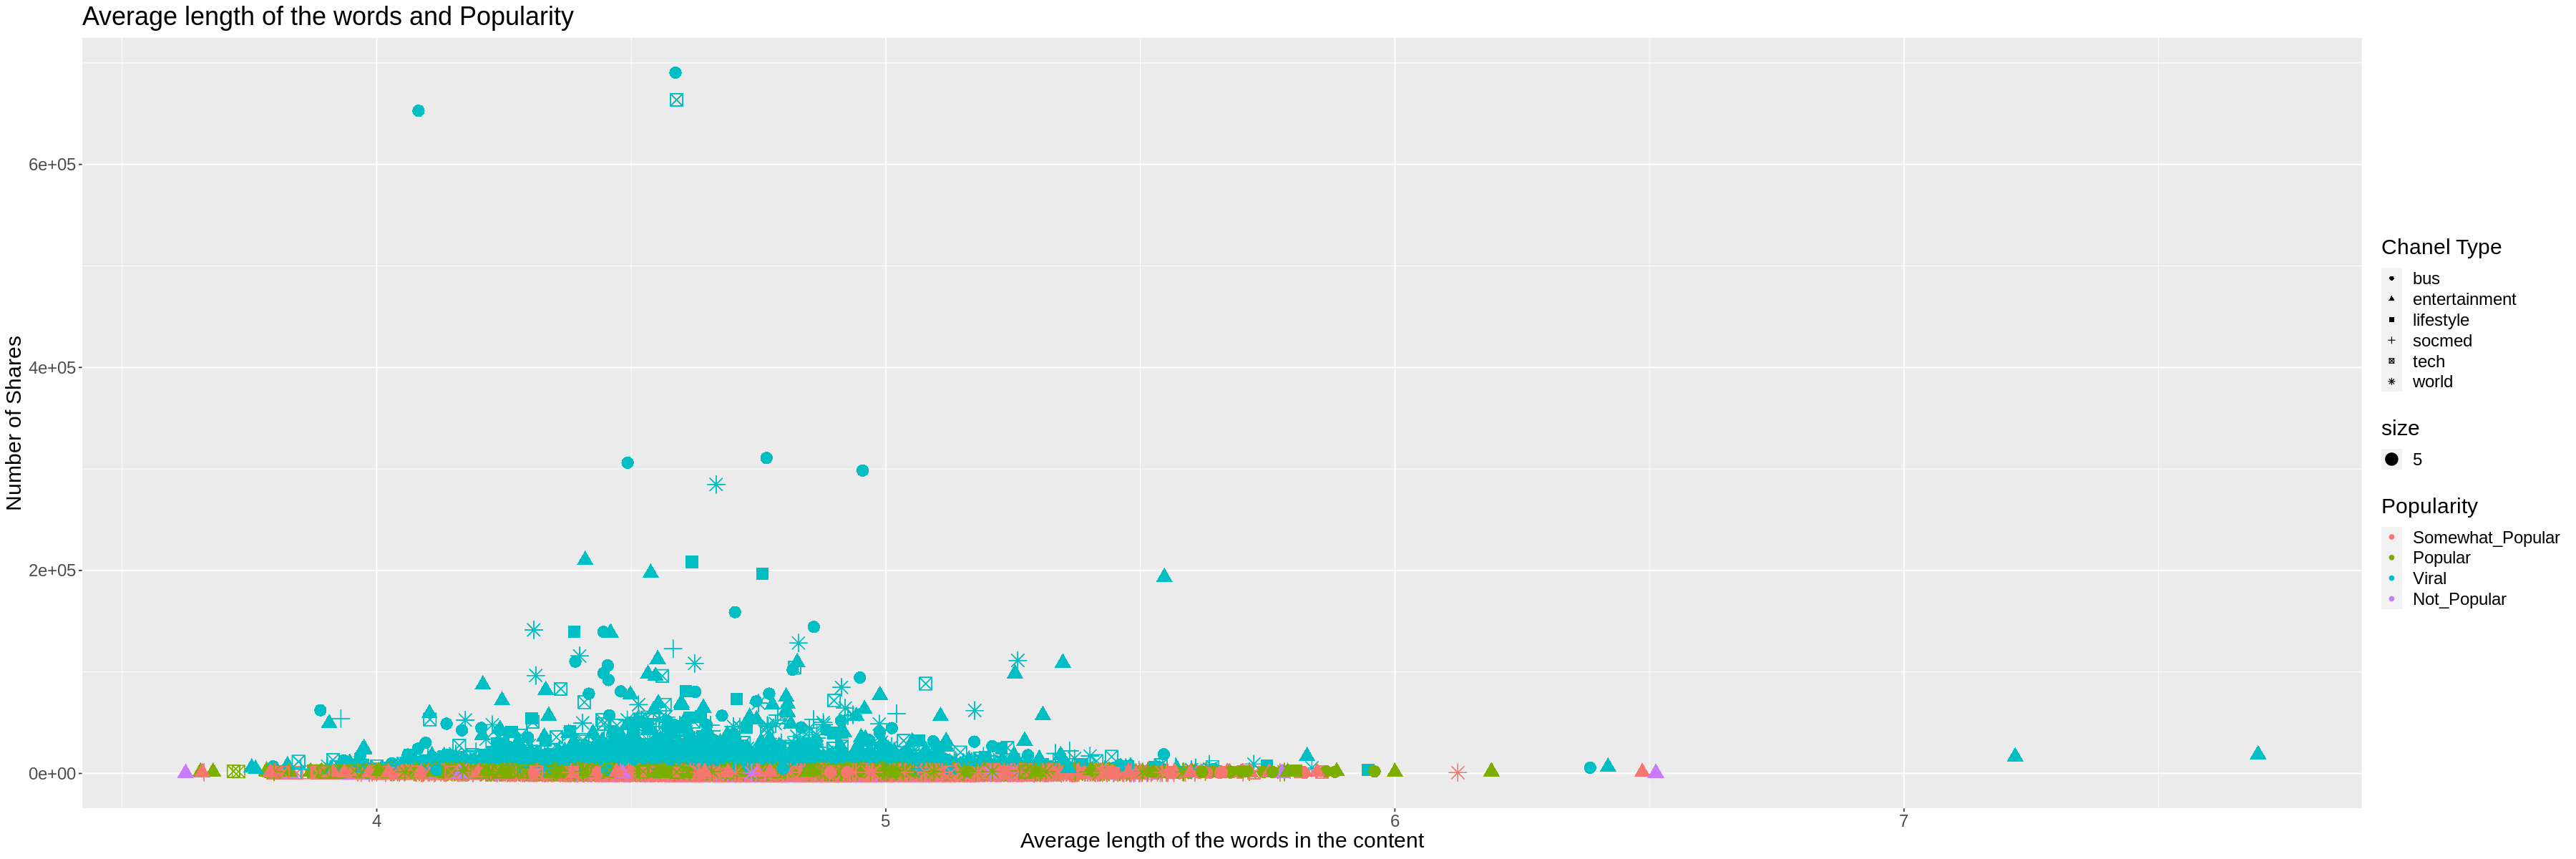

In [48]:
pltAvg_token_len = training_set %>% 
                filter(average_token_length > 0) %>% 
                ggplot(aes(x = average_token_length, y = shares)) +
                geom_point(aes(shape = Channel , color = popularity, size = 5)) + 
                labs( x = "Average length of the words in the content", y = "Number of Shares", 
                     color = "Popularity", shape = "Chanel Type",
                     title = "Average length of the words and Popularity") + 
                theme(text = element_text(size = 18))
pltAvg_token_len

# word length btw 4 & 5 viral
# bus 

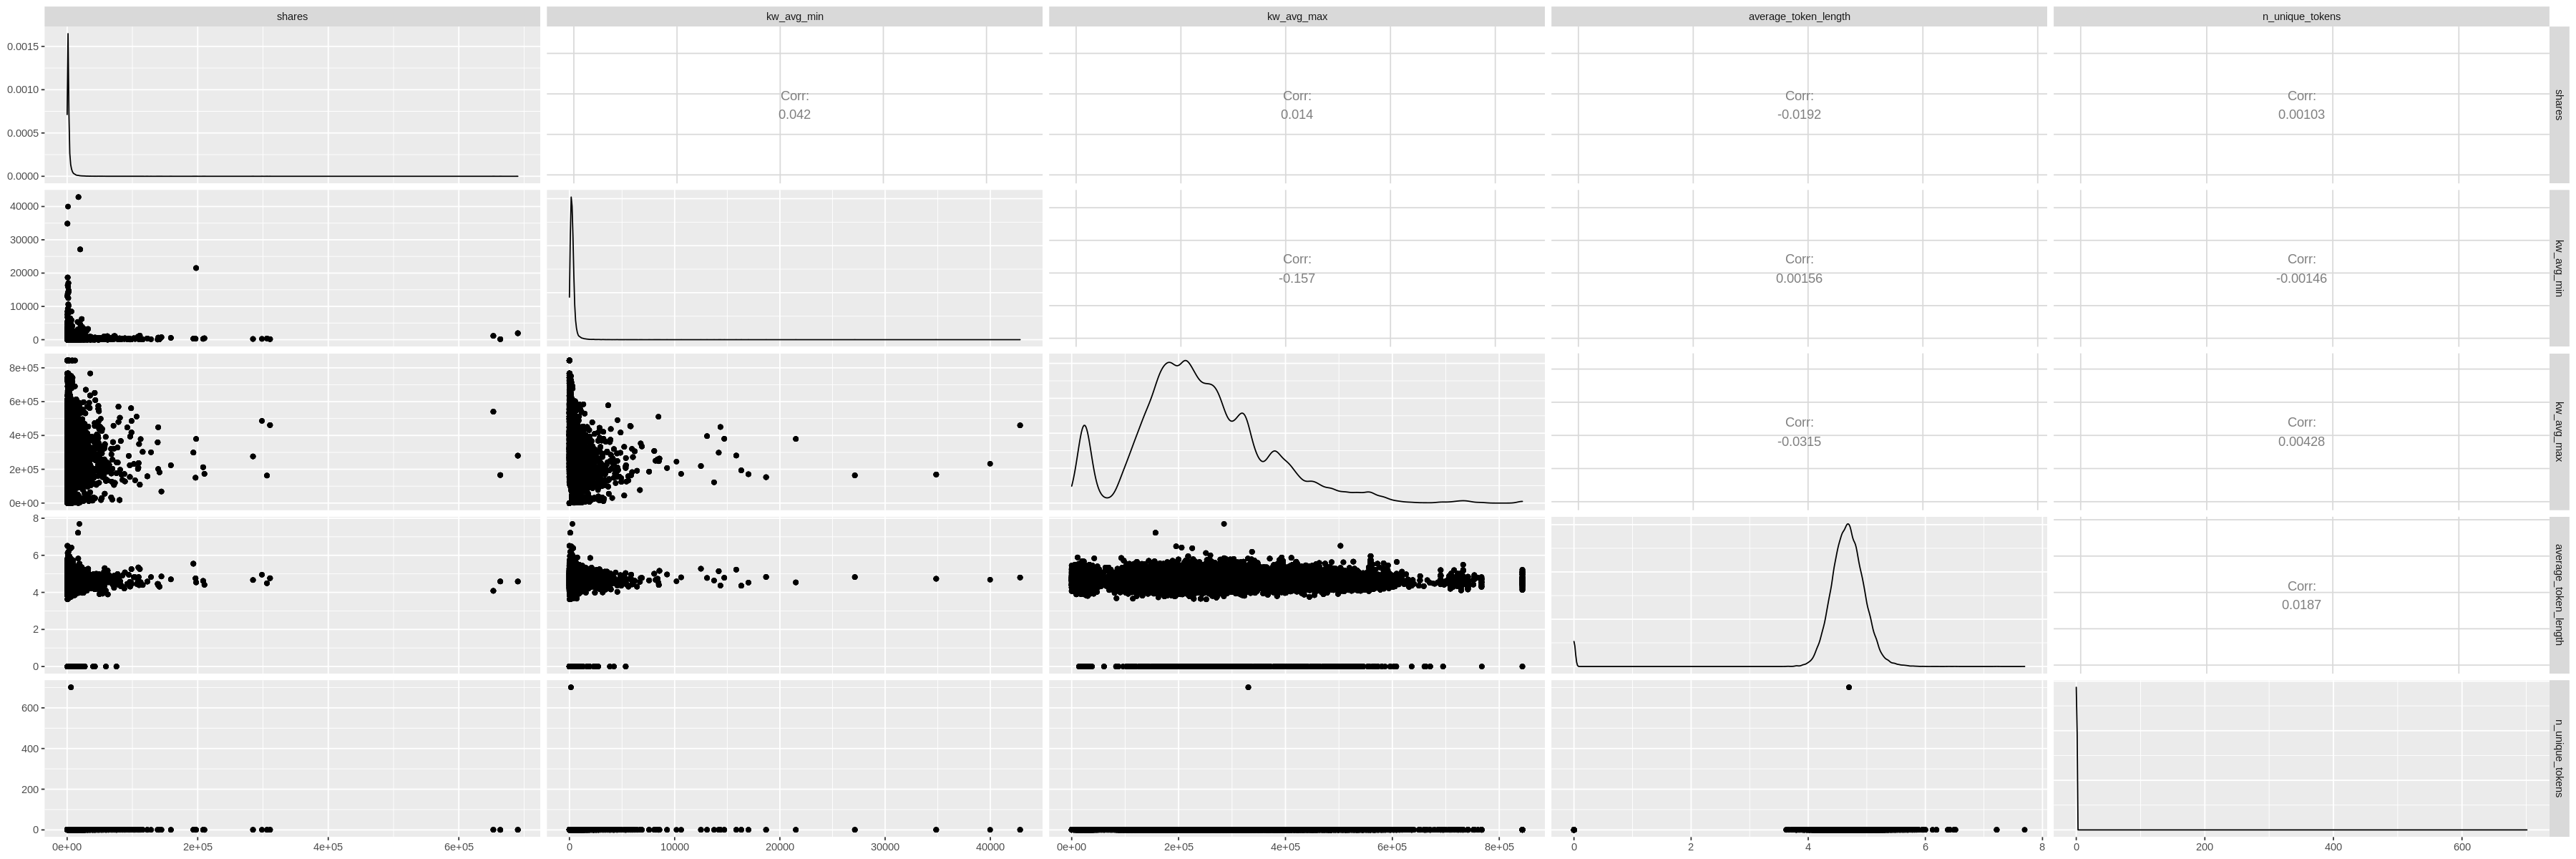

In [53]:
library(GGally)
ggpairs(training_set %>% select(c(shares, kw_avg_min,kw_avg_max, average_token_length, n_unique_tokens))) 

The plot above indicates that the most viral posts have an average word length of around 4-5 letters long. We also see that the business articles make the top 2/3 most shared posts

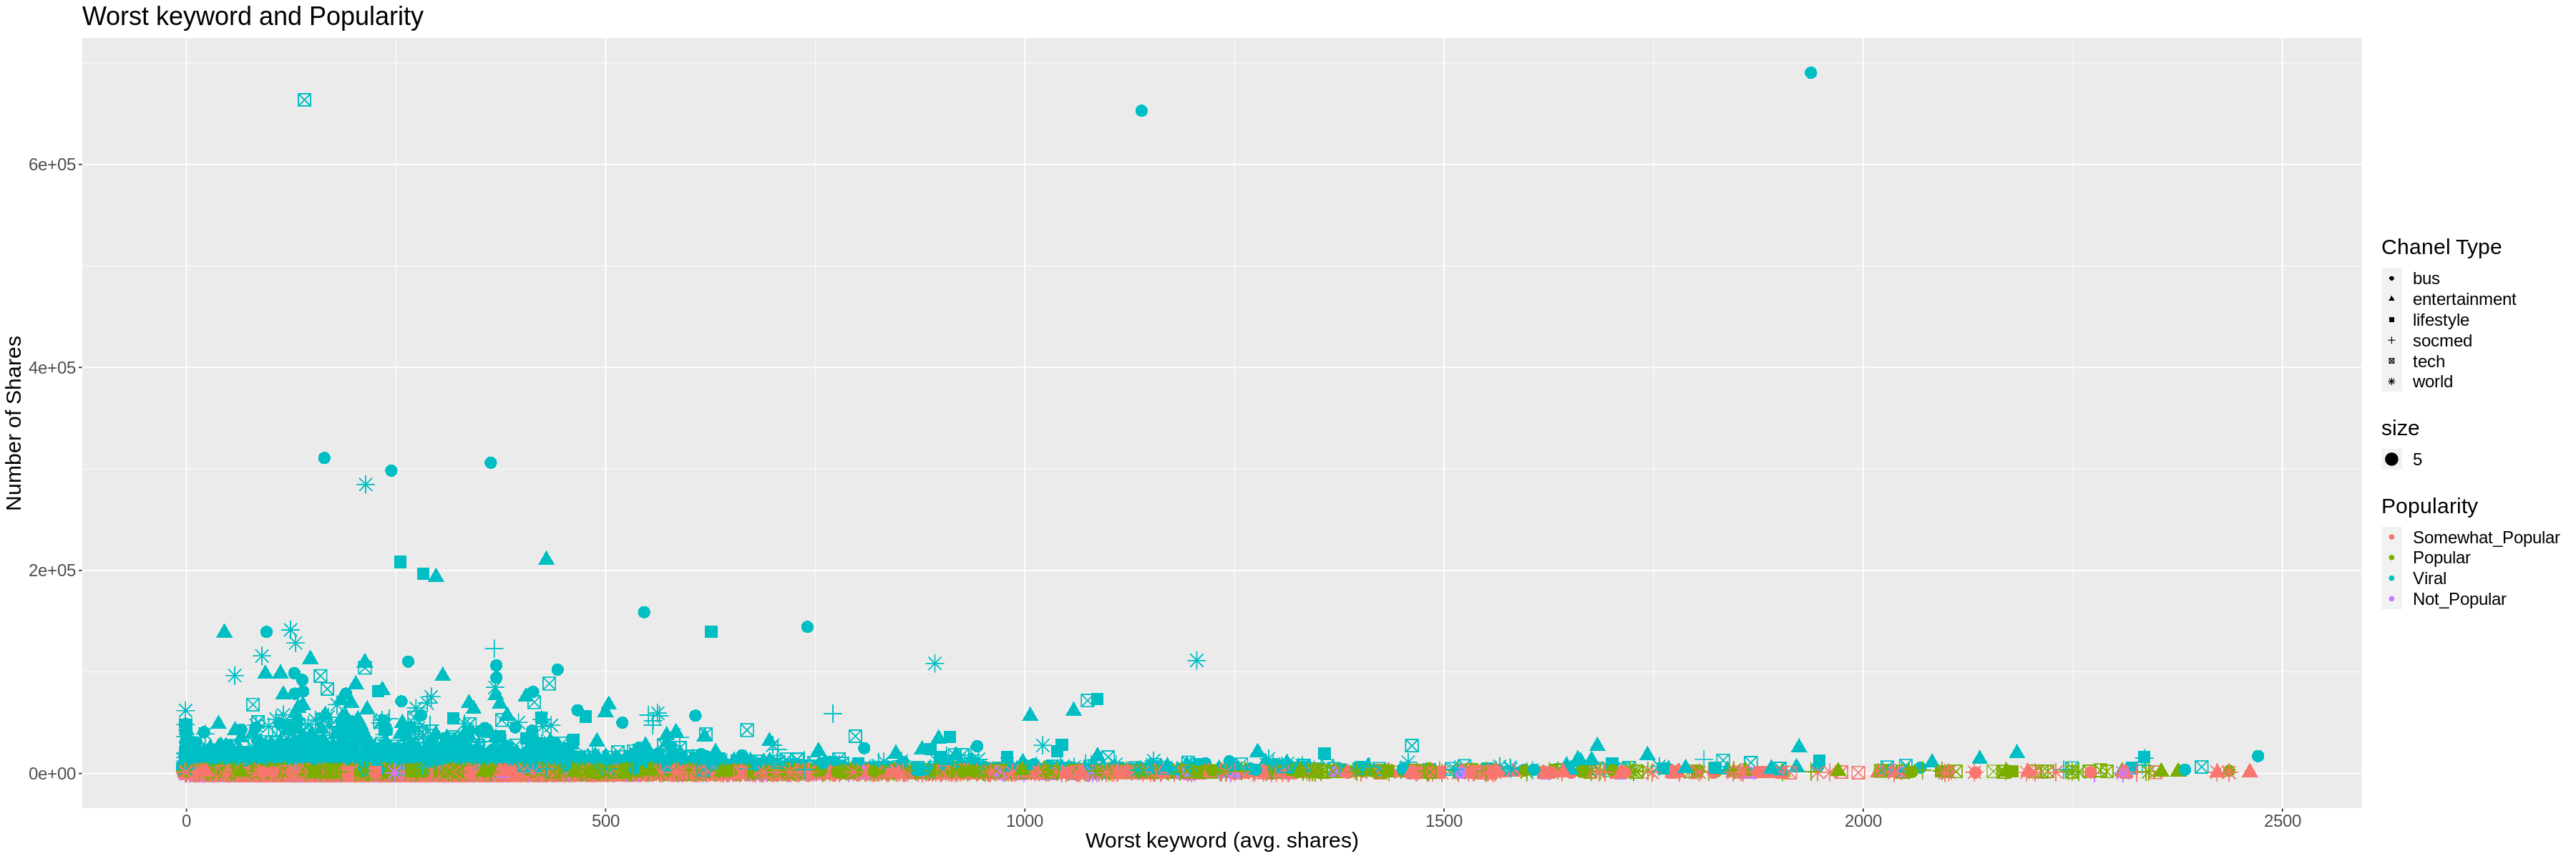

In [42]:

pltAvg_min = training_set %>% 
                filter(kw_avg_min < 10000) %>% 
                filter(kw_avg_min < 2500) %>% 
                ggplot(aes(x = kw_avg_min, y = shares)) +
                geom_point(aes(shape = Channel , color = popularity, size = 5)) + 
                labs( x = "Worst keyword (avg. shares)", y = "Number of Shares", 
                     color = "Popularity", shape = "Chanel Type",
                     title = "Worst keyword and Popularity") + 
                theme(text = element_text(size = 18))
pltAvg_min

# up to 500 => viral
# bus => viral

The plot above shows the predictor, kw_avg_min (worst average of shares for keywords). We see that the most viral posts have an average share below 500. We also see that the top 3 top posts are business related

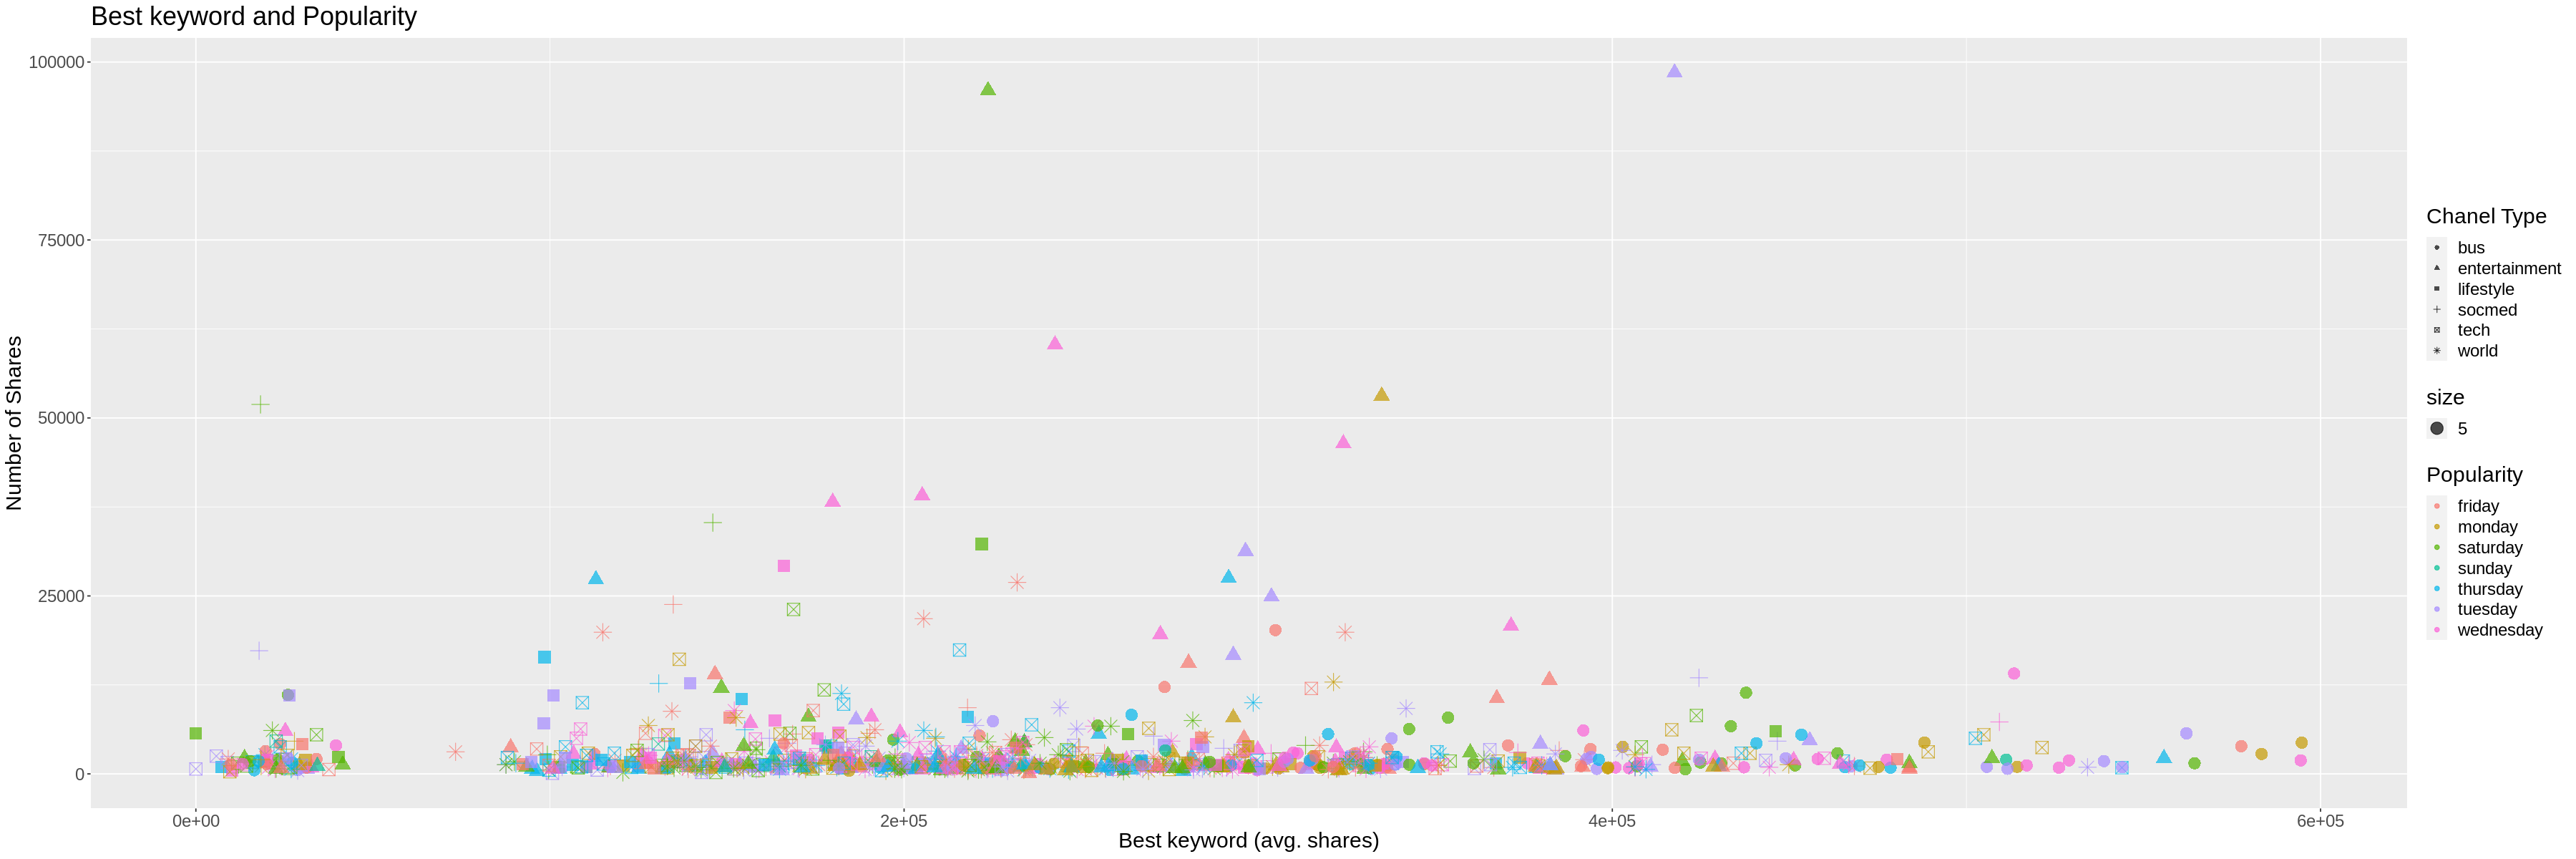

In [43]:
#Change this predictor to something else. Thinking about using weekdays instead
pltAvg_max = training_set %>%
                filter(kw_avg_max < 6e+05) %>% 
#                 filter(shares < 3300) %>% 
                sample_n(1000) %>% 
                ggplot(aes(x = kw_avg_max, y = shares)) +
                geom_point(alpha = 0.7, aes(shape = Channel , color = weekday, size = 5)) + 
                labs( x = "Best keyword (avg. shares)", y = "Number of Shares", 
                     color = "Popularity", shape = "Chanel Type",
                     title = "Best keyword and Popularity") + 
                theme(text = element_text(size = 18))
pltAvg_max


# To General, eliminate 

The plot above shows that that the kw_avg_max predictor shows that the most viral posts has a best keyword average shares roughly between 100,000-500,000 however this predictor may be too weakly correlated for our model. We will consider other predictors for future iterations of our project.

**Methods**


Like we mentioned in the preliminary exploratory, we cleaned the data 17 columns out of 61, which are about shared numbers, when the articles were published (Monday to Sunday), category of the articles (Lifestyle, Entertainment etc.), rate of unique words, average length, and both best and worst keywords. Those columns were thought to be connected with a shared number. Also, using the 4 categories about popularity we defined above, we separate the data and cut out outliers, and we use box plots and histogram to visualize. 


**Expected outcomes and significance**


We expect to find some kind of relationship between the columns of the dataset and the popularity. Also, considering the amount of columns we already have in the dataset, it would not be a surprise if the relationship is not easily visible to human visualization. Such a relationship will however be examined on how well it can predict the popularity of a new observation. Such findings can help us understand what are some properties of news articles that make them popular. 
It can lead to further questions such as which column have more profound impact on popularity? Or do the columns responsible for popularity different for different types of topics?
 
